In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools
from sklearn.preprocessing import scale
import ipywidgets as widgets
from ipywidgets import interact

In [8]:
#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

In [14]:
bjds = np.load('Data/bjds.npy')
fluxes = np.load('Data/fluxes.npy')
fluxerrs = np.load('Data/fluxerrs.npy')
postfluxes200 = np.load('Data/processed_lcs_200pc.npy')
postfluxes200 = postfluxes200/postfluxes200.std(axis=0)

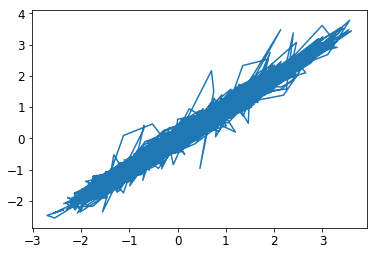

In [23]:
postfluxes1000= np.load('Data/processed_lcs_1000pc.npy')
postfluxes1000 = postfluxes1000/postfluxes1000.std(axis=0)
plt.plot(postfluxes200[0], postfluxes1000[0])

0.9975901734029855 1.075976576542995
1.0136242057371572 0.9594657937030088
0.9956565269408592 1.0054063979318493
1.0307454122628368 0.8989933191084925
1.0883649184246982 0.7517155287116075
0.9890280188254201 1.0021705062336077
0.9992861990050538 1.1355072889674171
0.9999159250373761 0.891504229791255
1.00438843913475 0.9384458637219876


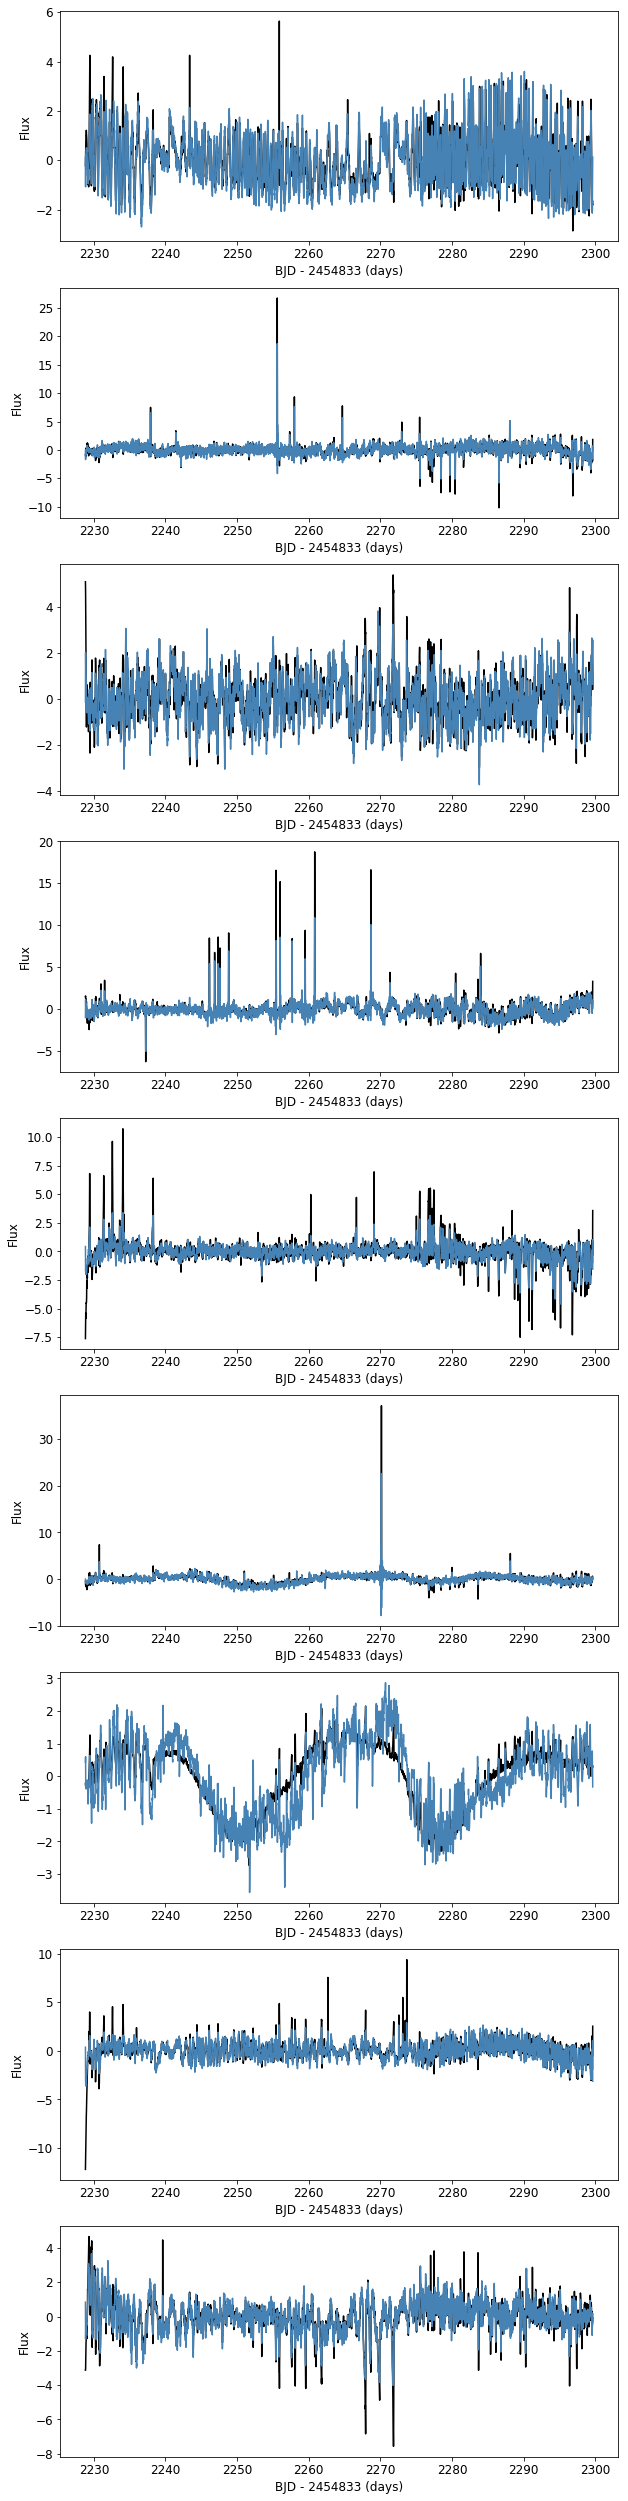

In [24]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i][:-1], fluxes[i][:-1], c='k')
  print(fluxes[i][:-1].std(), postfluxes200[i][:-1].std())

  axes[p].plot(bjds[i][:-1], postfluxes200[i], c='SteelBlue')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

0.9975901734029855 1.0606054399370715
1.0136242057371572 0.9760007629456364
0.9956565269408592 1.0401014882505626
1.0307454122628368 0.9192832051447862
1.0883649184246982 0.7910120016136906
0.9890280188254201 1.001076343223374
0.9992861990050538 1.1078211189956186
0.9999159250373761 0.9333503368605228
1.00438843913475 0.9356060297041399


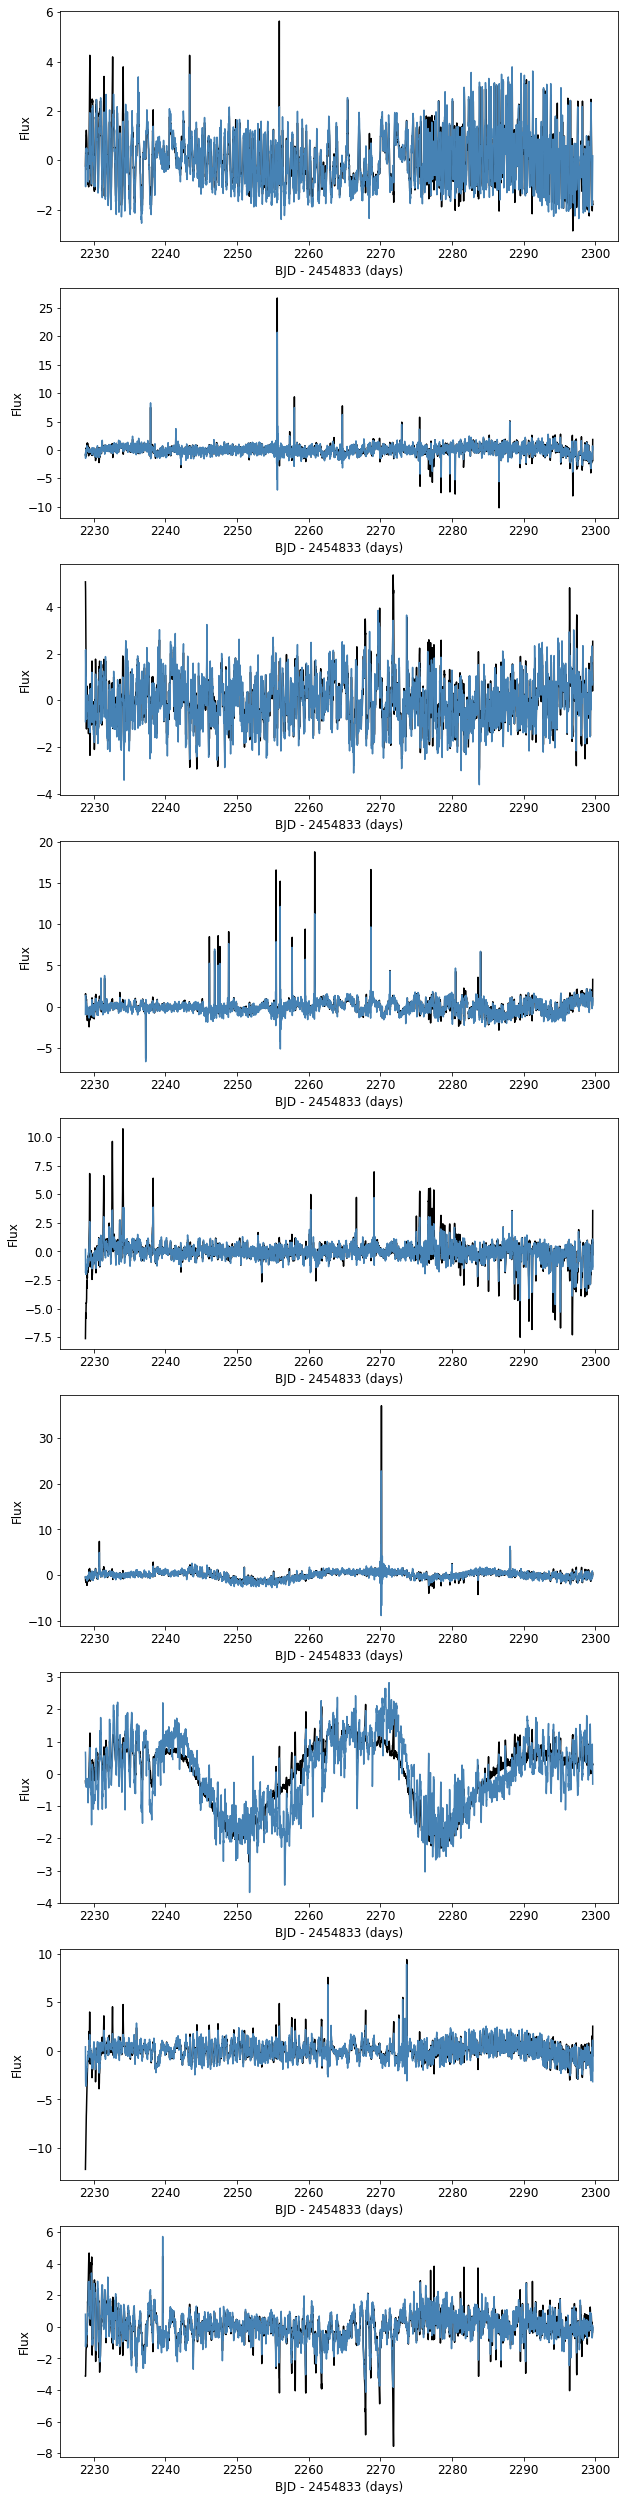

In [25]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i][:-1], fluxes[i][:-1], c='k')
  print(fluxes[i][:-1].std(), postfluxes1000[i][:-1].std())

  axes[p].plot(bjds[i][:-1], postfluxes1000[i], c='SteelBlue')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

In [42]:
def plotme(time1, flux1norm, Filtered_signal1, sig2 = None, xmin=None, xmax=None):
  fig = plt.figure(figsize=(10,5))
  
  res = flux1norm - Filtered_signal1
  left, width = 0.1, 1.32
  if not sig2 is None:
        fig = plt.figure(figsize=(20,5))
        res2 = flux1norm - sig2
        left, width = 0.1, 0.66
  bottom, height = 0.1, 0.66

  rect_scatter1 = [left, bottom + 0.2, width/2, height]
  rect_histx1 = [left, bottom, width/2, 0.2]
  if not sig2 is None:
    rect_scatter2 = [left+width/2, bottom + 0.2, width/2, height]
    rect_histx2 =[left+width/2, bottom, width/2, 0.2]
  plt.subplots_adjust(hspace=0., wspace=0.1)
  ax1 = plt.axes(rect_scatter1)
  axres1 = plt.axes(rect_histx1)
  if not sig2 is None:
    ax2 = plt.axes(rect_scatter2)
    axres2 = plt.axes(rect_histx2)
  ax1.minorticks_on()
  axres1.minorticks_on()  
  if not sig2 is None:
    ax2.minorticks_on()
    axres2.minorticks_on()
    plt.setp(ax2.get_xticklabels(),
             visible=False)
    ax2.yaxis.tick_right()
    axres2.yaxis.tick_right()

  ax1.errorbar(time1, flux1norm, color='SteelBlue', alpha=1,
                                 marker='.', fmt='.', label='Original')
  ax1.errorbar(time1, Filtered_signal1,
                                 color='DarkOrange', alpha=0.25,
                                 marker='.', fmt='.', label='Filtered')
  ax1.set_ylabel('Standarized Flux')
  ax1.legend(fontsize=12)

  axres1.plot(time1, res, color='k', alpha=0.5)
  axres1.set_ylabel('Residuals')
    
  if not sig2 is None:
    ax2.errorbar(time1, flux1norm, color='SteelBlue', alpha=1,
                                 marker='.', fmt='.', label='Original')
    ax2.errorbar(time1, sig2,
                                 color='DarkOrange', alpha=0.25,
                                 marker='.', fmt='.', label='Filtered')
    
    ax2.legend(fontsize=12)

    axres2.plot(time1, res2, color='k', alpha=0.5)
    
  if xmin is None:
        xmin=time1[0]
  if xmax is None:
        xax=time1[-1]
            
  ax1.set_xlim(xmin, xmax)
  #ax1.set_ylim(-2,2)
  axres1.set_xlim(xmin, xmax)
  if not sig2 is None:
      ax2.set_xlim(xmin, xmax)
      #ax1.set_ylim(-2,2)
      axres2.set_xlim(xmin, xmax)
  

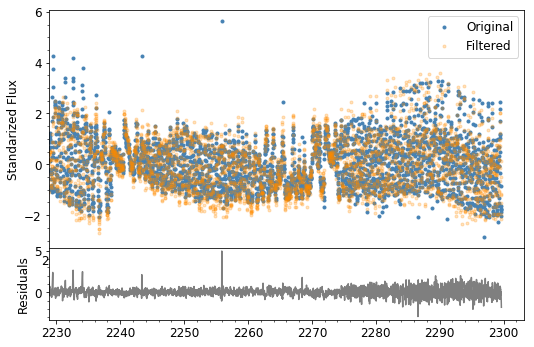

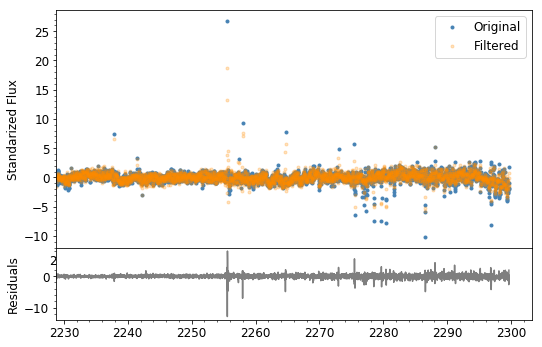

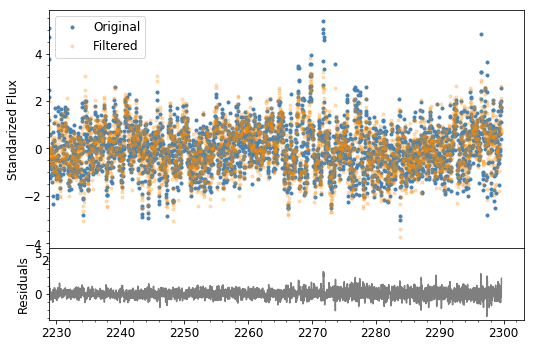

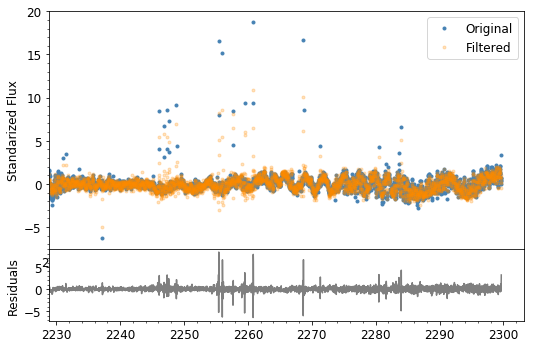

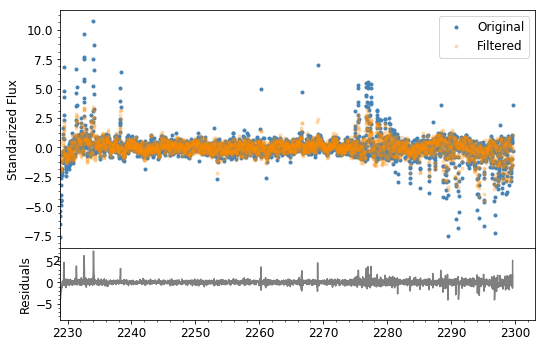

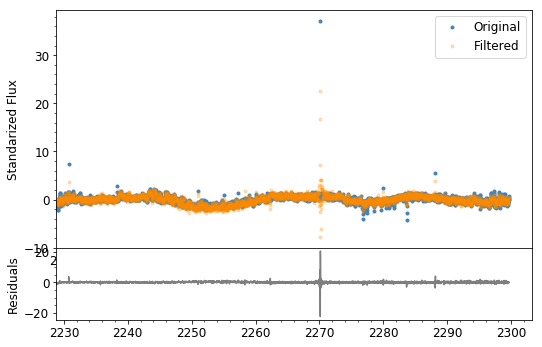

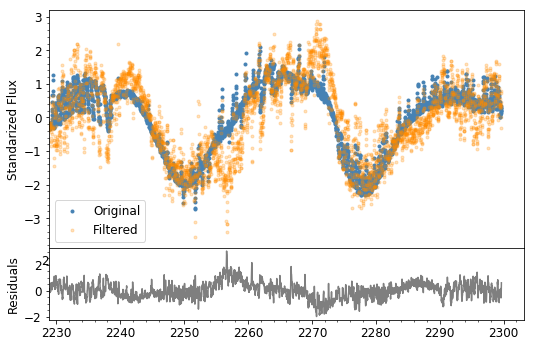

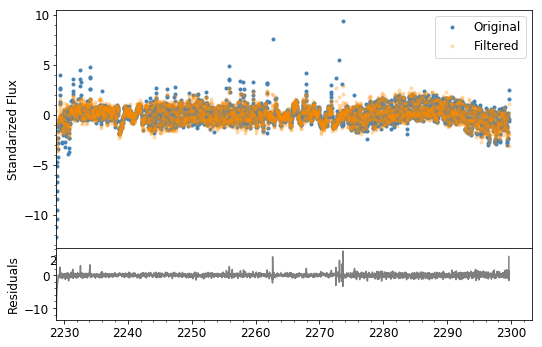

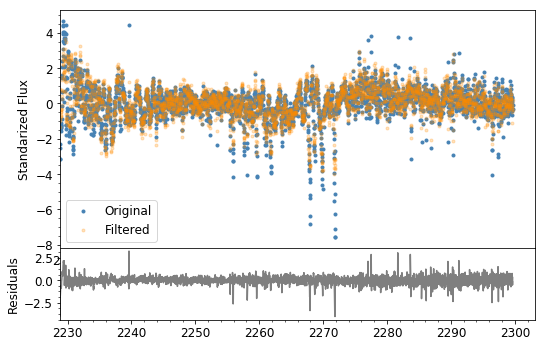

In [43]:
for  i in range(0,900,100):
    
    plotme(bjds[i][:-1], fluxes[i][:-1], postfluxes[i])

In [44]:
import pandas as pd
pcacoefs = pd.read_csv("Data/coeffs.csv")
pcacoefs.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5
0,0,0.037755,0.043406,-0.003863,-0.032495,-0.004479
1,1,0.026269,-0.000337,-0.038874,-0.048884,-0.020208
2,2,0.029975,-0.005274,-0.038515,-0.021123,0.013898
3,3,0.031498,0.000082,0.012302,-0.049789,-0.031301
4,4,0.027876,0.105999,-0.007031,0.032938,0.026401


<Figure size 720x360 with 0 Axes>

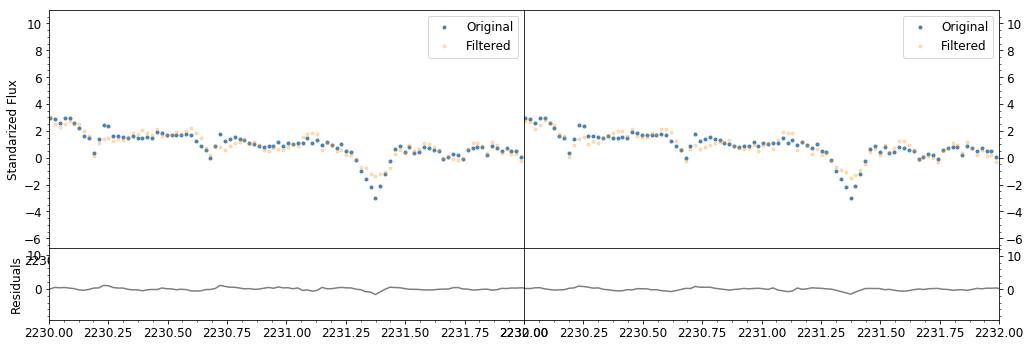

<Figure size 720x360 with 0 Axes>

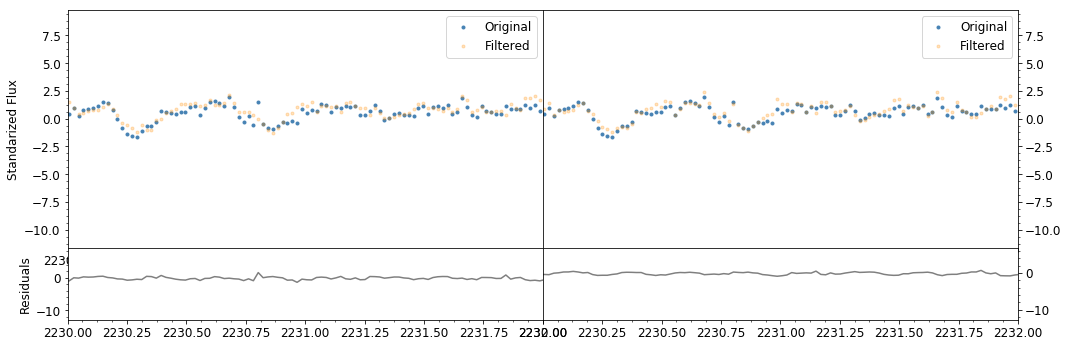

<Figure size 720x360 with 0 Axes>

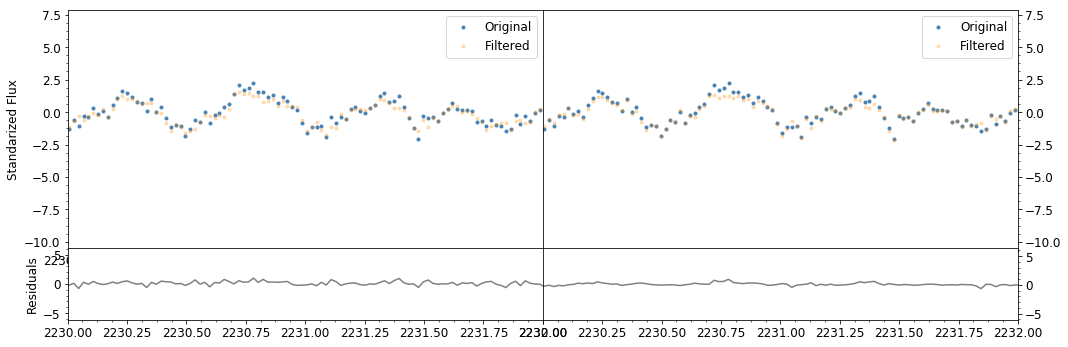

<Figure size 720x360 with 0 Axes>

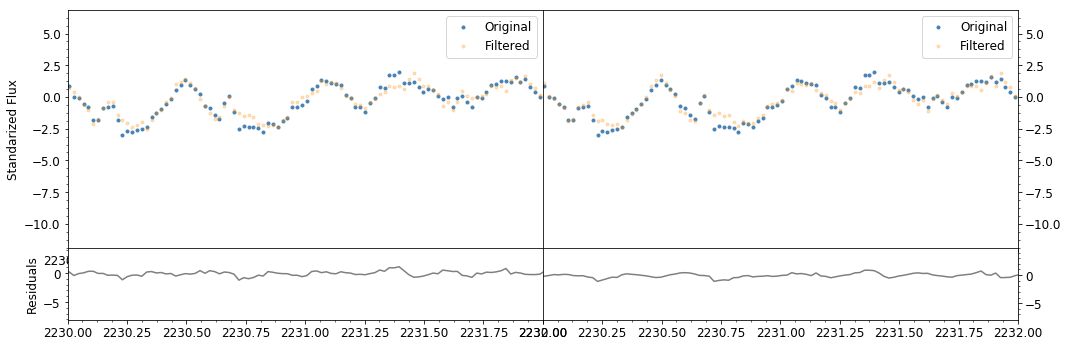

<Figure size 720x360 with 0 Axes>

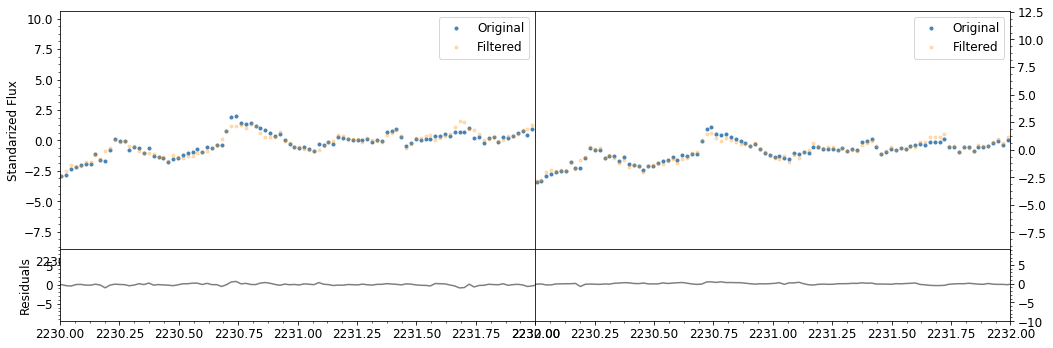

<Figure size 720x360 with 0 Axes>

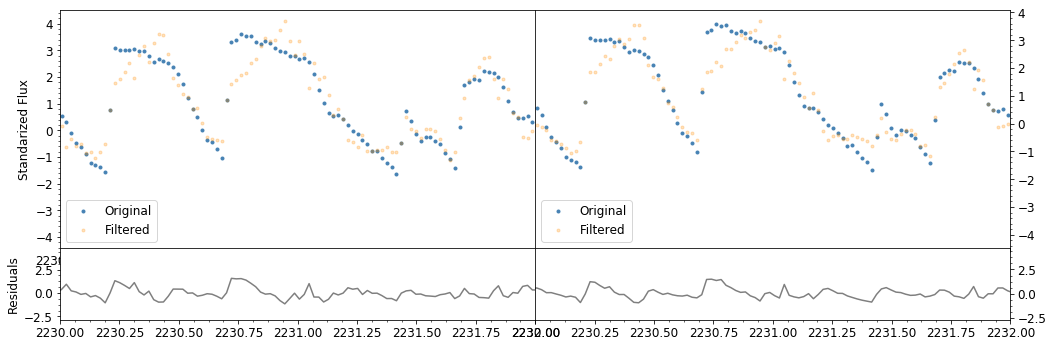

<Figure size 720x360 with 0 Axes>

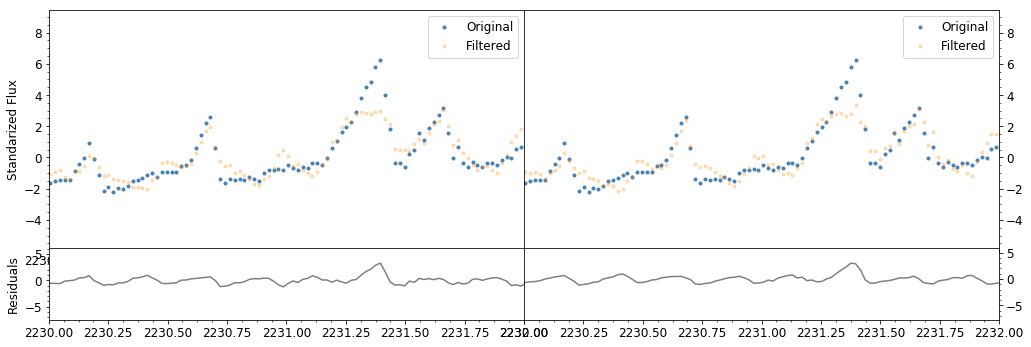

<Figure size 720x360 with 0 Axes>

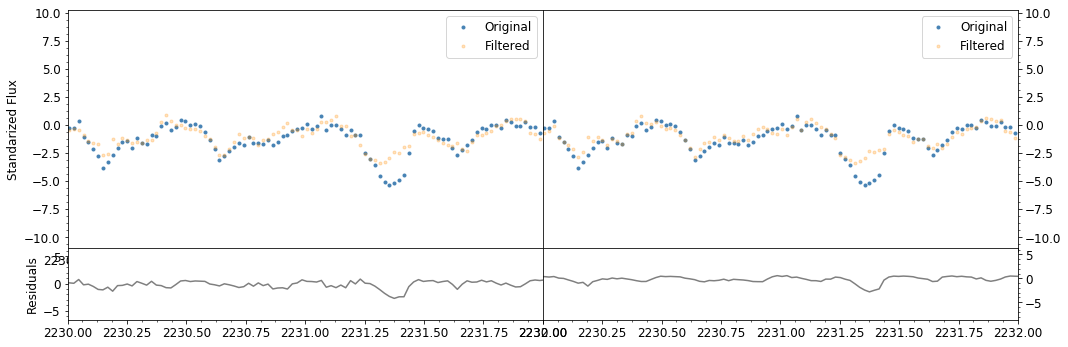

<Figure size 720x360 with 0 Axes>

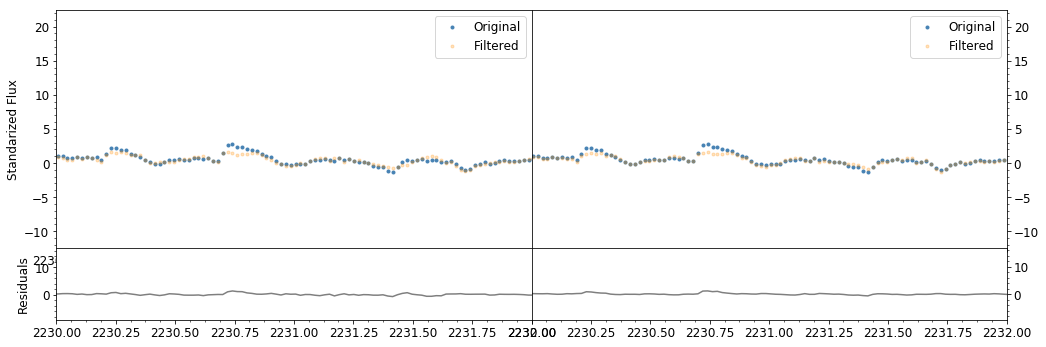

<Figure size 720x360 with 0 Axes>

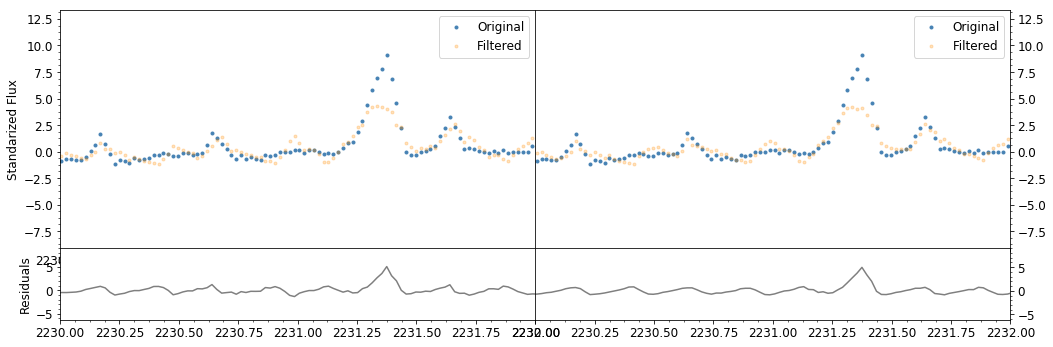

In [45]:
for i in pcacoefs.sort_values(["pc1","pc2"], ascending=False).index[:10]:
    plotme(bjds[i][:-1], fluxes[i][:-1], postfluxes200[i], postfluxes1000[i], 
           xmin=2230, xmax=2232)
    